In [1]:
import os
import torchvision
from PIL import Image
from torchvision import datasets, models, transforms
import torch

# number of subprocesses to use for data loading
num_workers = 0
classes=133
input_size=299

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transform = transforms.Compose([
         transforms.RandomRotation(30),
         transforms.RandomHorizontalFlip(),
         transforms.RandomResizedCrop(input_size),            
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])

transform = transforms.Compose([
         transforms.Resize(input_size),                    
         transforms.CenterCrop(input_size),                
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder('dogImages/train', transform=train_transform, target_transform=None, loader=Image.open, is_valid_file=None)
valid_data = torchvision.datasets.ImageFolder('dogImages/valid', transform=transform, target_transform=None, loader=Image.open, is_valid_file=None)
test_data = torchvision.datasets.ImageFolder('dogImages/test', transform=transform, target_transform=None, loader=Image.open, is_valid_file=None)

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# instantiate the CNN
model_transfer = models.inception_v3(pretrained=True)

print(model_transfer)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
# Deactivate gradient for pretrained layers - Prevents them from training
for param in model_transfer.parameters():
            param.requires_grad = False
    
# new layers automatically have requires_grad = True
model_transfer.AuxLogits.fc = nn.Linear(768, len(train_data.classes))
model_transfer.fc = nn.Linear(2048, len(train_data.classes))


# check to see that your last layer produces the expected number of outputs
print('Output Count: {}'.format(model_transfer.fc.out_features))

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()

Output Count: 133


In [5]:
from torchsummary import summary
summary(model_transfer, (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

In [6]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, starting_loss):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = starting_loss 
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs, aux_outputs = model(data)
            loss1 = criterion(outputs, target)
            loss2 = criterion(aux_outputs, target)
            loss = loss1 + 0.4*loss2
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)----------------------------------------------------------------
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
           if use_cuda:            
               data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
           output = model(data)
            # calculate the batch loss
           loss = criterion(output, target)
            # update average validation loss 
           valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model




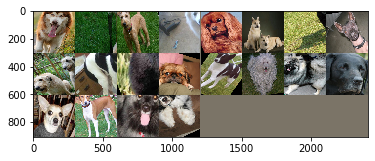

Training Data inputs torch.Size([20, 3, 299, 299])  Classestorch.Size([20])


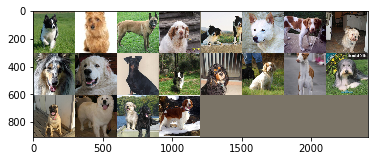

Validation Data inputs torch.Size([20, 3, 299, 299])  Classestorch.Size([20])


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from glob import glob

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    
# how many samples per batch to load
batch_size = 20 #lowered batch size due to running out of memory

# prepare data loaders - had to move them because of changing the batch size
loaders_transfer={}
loaders_transfer['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
loaders_transfer['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)
loaders_transfer['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(loaders_transfer['train'])
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(loaders_transfer['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)
print('Training Data inputs {}  Classes{}'.format(inputs.shape, classes.shape))
      
# obtain one batch of training images
dataiter2 = iter(loaders_transfer['valid'])
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(loaders_transfer['valid']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)
print('Validation Data inputs {}  Classes{}'.format(inputs.shape, classes.shape))

In [8]:
import torch.optim as optim

### TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9, nesterov=True)

training_from_base=False
update_training=False

In [9]:
#Training from scratch
if(training_from_base):
    #change the starting_loss if continuing on a saved model.
    starting_loss=np.inf
    # train the model
    model_transfer = train(200, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, '/home/paolo/models/model_transfer_inception.pt', starting_loss)

    # load the model that got the best validation accuracy
    model_transfer.load_state_dict(torch.load('/home/paolo/models/model_transfer_inception.pt'))

In [10]:
#reload and continue training
if(update_training):   
    model_transfer.load_state_dict(torch.load('/home/paolo/models/model_transfer_inception.pt'))
    if use_cuda:
        model_transfer.cuda()

    #change the starting_loss if continuing on a saved model.
    starting_loss=1.778868
    # train the model
    model_transfer = train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, '/home/paolo/models/model_transfer_inception.pt', starting_loss)

    # load the model that got the best validation accuracy
    model_transfer.load_state_dict(torch.load('/home/paolo/models/model_transfer_inception.pt'))

In [11]:
import weightwatcher as ww

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('/home/paolo/models/model_transfer_inception.pt'))

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.


    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        #if use_cuda:
        #    data, target, model = data.cuda(), target.cuda(), model.cuda()
        data, target, model = data.cpu(), target.cpu(), model.cpu()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    watcher = ww.WeightWatcher(model)
    results = watcher.analyze(plot=True)
    summary = watcher.get_summary()
    details = watcher.get_details()
    
    print("Weight Watcher Summary")
    print(watcher.print_results)

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Using TensorFlow backend.
2020-04-06 01:16:47,015 INFO 

python      version 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
numpy       version 1.18.1
tensforflow version 2.2.0-dev20200401
keras       version 2.3.1
2020-04-06 01:16:47,017 INFO Analyzing model


Test Loss: 0.419105


Test Accuracy: 87% (730/836)


2020-04-06 01:16:47,659 INFO ### Printing results ###
2020-04-06 01:16:57,049 INFO Check: min: 0.011724229796236002, max: 2.9578561273342165, avg: 0.8464795339544202
2020-04-06 01:16:57,049 INFO Check compound: min: 0.011724229796236002, max: 2.1972475118303816, avg: 0.4917728539589265
2020-04-06 01:16:57,050 INFO CheckTF: min: False, max: True, avg: 0.8167330677290837
2020-04-06 01:16:57,052 INFO CheckTF compound: min: 0.0, max: 1.0, avg: 0.48643990929705216
2020-04-06 01:16:57,052 INFO Norm: min: 4.187047481536865, max: 15.80726432800293, avg: 7.669793605804443
2020-04-06 01:16:57,053 INFO Norm compound: min: 4.325076103210449, max: 14.769170761108398, avg: 7.7967000007629395
2020-04-06 01:16:57,054 INFO LogNorm: min: 0.6219078898429871, max: 1.1988567113876343, avg: 0.862952470779419
2020-04-06 01:16:57,055 INFO LogNorm compound: min: 0.6359937787055969, max: 1.169356107711792, avg: 0.8709214925765991
2020-04-06 01:16:57,056 INFO Norm X: min: 1.9509638547897339, max: 66.091026306152

Weight Watcher Summary
<bound method WeightWatcher.print_results of 
Analysis done: True>


In [15]:
model_transfer.load_state_dict(torch.load('/home/paolo/models/model_transfer_inception.pt'))

transform = transforms.Compose([
         transforms.Resize(input_size),                    
         transforms.CenterCrop(input_size),                
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

classes = train_data.classes

testimage = image_loader(transform, 'oneoff/malcolm.jpg')

def test(timage, model, use_cuda): 
    model.eval()
    # move to GPU
    if use_cuda:
        model.cuda()
        timage = timage.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    testoutput = model(timage)
    # convert output probabilities to predicted class
    pred = testoutput.data.softmax(dim=1).topk(5)
    # compare predictions to true label
    indices = pred[1]
    for ind in range(len(indices[0])):
        print('{}. {:>6.2%} - {} '.format(ind, pred[0][0][ind], classes[indices[0][ind]]))
    #print('Results : {} {} {} {} {}'.format(
    #    classes[pred[1][0]]), classes[pred[1][1]], classes[pred[1][2]], classes[pred[1][3]], classes[pred[1][4]]
    #     )


# call test function    
test(testimage, model_transfer, use_cuda)


0. 48.81% - 005.Alaskan_malamute 
1.  5.94% - 110.Norwegian_lundehund 
2.  3.60% - 109.Norwegian_elkhound 
3.  2.07% - 043.Canaan_dog 
4.  1.91% - 095.Kuvasz 


/home/paolo/anaconda3/envs/udacity2/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
